# Data Normalization: *Part 2*
#### **Skew Transformation: Market Cap**

In [119]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import zscore
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# create dataframe
df = pd.read_csv('GHG_Post_Outlier.csv')
# remove scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)  

data.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,country_ghg_avg,country_population_avg,country_gdp_avg
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Purchased goods and services,17.62,428.77,67346924.78,3038320070320.49
1,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Fuel-and-energy-related activities (not includ...,61.42,428.77,67346924.78,3038320070320.49
2,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Waste generated in operations,57.21,428.77,67346924.78,3038320070320.49
3,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Business travel,2549.33,428.77,67346924.78,3038320070320.49
4,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Employee commuting,3.90,428.77,67346924.78,3038320070320.49


## EDA and Normalization: Skewness and Transformation

In [121]:
df['Market_Cap_USD'].describe()

count           37591.00
mean      42133812785.34
std      228108347219.05
min           2449135.49
25%        2869318806.84
50%        8135037017.00
75%       25396957209.60
max     6283031666323.00
Name: Market_Cap_USD, dtype: float64

In [123]:
# Check number of null values
print("Number of null values:", df['Market_Cap_USD'].isnull().sum())

# Check percentage of null values
print("Percentage of null values: {:.2f}%".format(
    (df['Market_Cap_USD'].isnull().sum() / len(df)) * 100))

Number of null values: 6488
Percentage of null values: 14.72%


#### *Remove Accounts with NULL Market Cap*

In [125]:
# Print original number of rows
print("Original number of rows:", len(df))

# Remove rows with null values in Market_Cap_USD
df = df.dropna(subset=['Market_Cap_USD'])

# Print new number of rows
print("Number of rows after removing nulls:", len(df))

# Verify no nulls remain
print("Number of nulls remaining:", df['Market_Cap_USD'].isnull().sum())

Original number of rows: 44079
Number of rows after removing nulls: 37591
Number of nulls remaining: 0


### **Analyzing Skew**

**Data has a positive/right skew when**:
   - Long tail extends to the right
   - Most values cluster on the left
   - Mean > Median

**Interpretation**:
   - When skewness is > 1, the data is highly skewed
   - A Fisher kurtosis of 0 indicated perfect normal distribution. The farther from 0, the less normal-like tails.

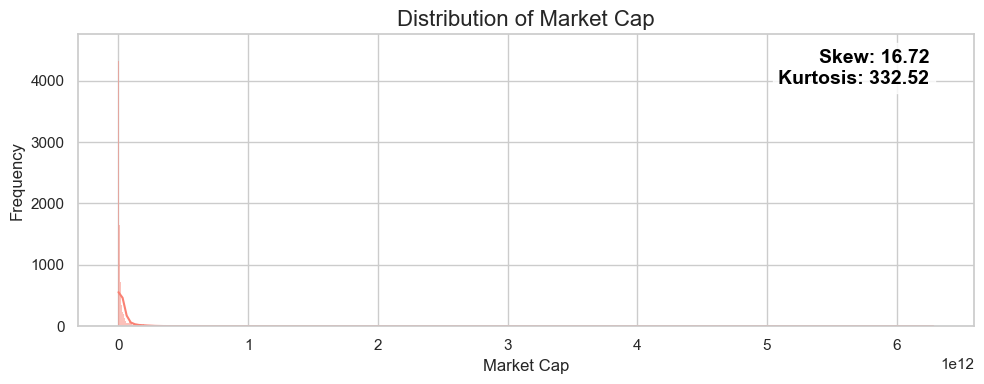

In [127]:
# Calculate skewness and kurtosis
original_skew = data['Market_Cap_USD'].skew()
original_kurtosis = data['Market_Cap_USD'].kurtosis()

# Set the style of seaborn
sns.set(style='whitegrid')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 4))

# Plot for Market Cap
sns.histplot(data['Market_Cap_USD'], kde=True, ax=ax, color='salmon')
ax.set_title('Distribution of Market Cap', fontsize=16)
ax.set_xlabel('Market Cap')
ax.set_ylabel('Frequency')

# Annotate Skewness and Kurtosis
ax.text(0.95, 0.95, f'Skew: {original_skew:.2f}\nKurtosis: {original_kurtosis:.2f}', 
        transform=ax.transAxes,
        horizontalalignment='right', 
        verticalalignment='top',
        color='black', 
        weight='bold',
        fontsize=14,
        bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

The skew on Market cap is very high, similar to Scope 3 Emissions amount. It is not surprising the skew on Market Cap is significant because this was not normalized in the previous process and the data includes companies of all sizes and revenues. I want to test different transformations on Market Cap to better normalize this feature for machine learning. In reality, it may also require outlier removal and validation.

### Applying Transformations

The main transformers that work best with the type of skewness and outlier considerations include:

**Quantile Transformer**
  - Best for non-normal distributions where data is heavily skewed
  - Robust to outliers and reduces the impact of extreme values
  - Uses quantiles information and maps data to either a uniform or normal distribution
  - Disadvantge: loses absolute value relationships

**Box Cox**
 - Makes non-normal data more normal-like, reduces skewness, stabilizes variance
 - Helps meet assumptions for many statistical tests by assuming linear model assumptions
 - Disadvantage: Only works with positive values and cannot handle zeros

#### Quantile Transformation (*Normal Distribution*)

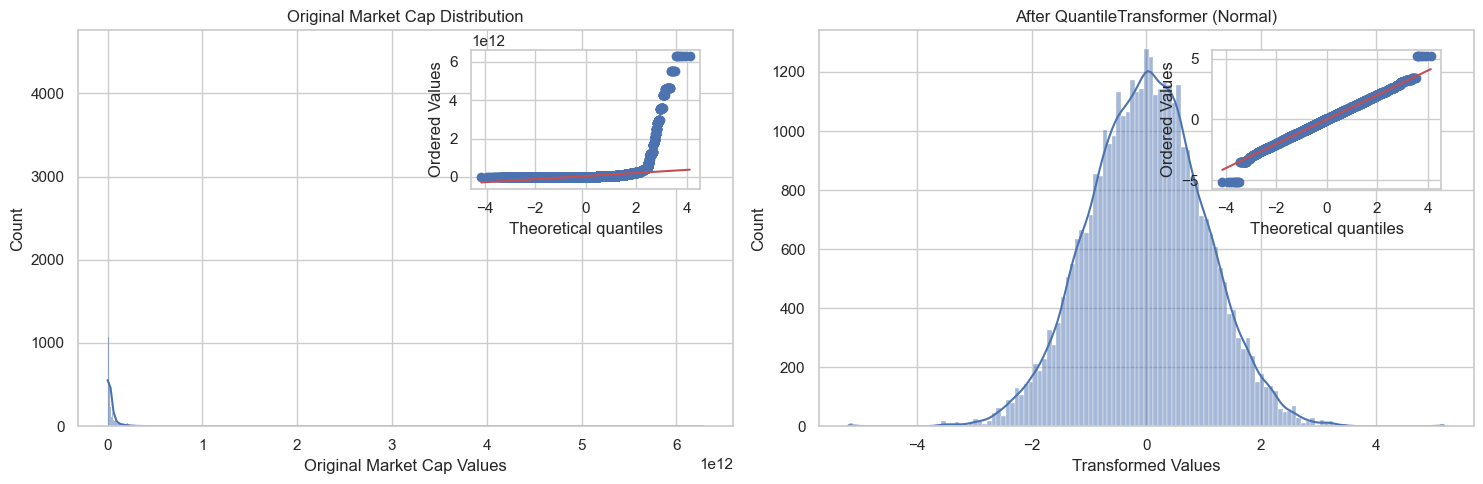

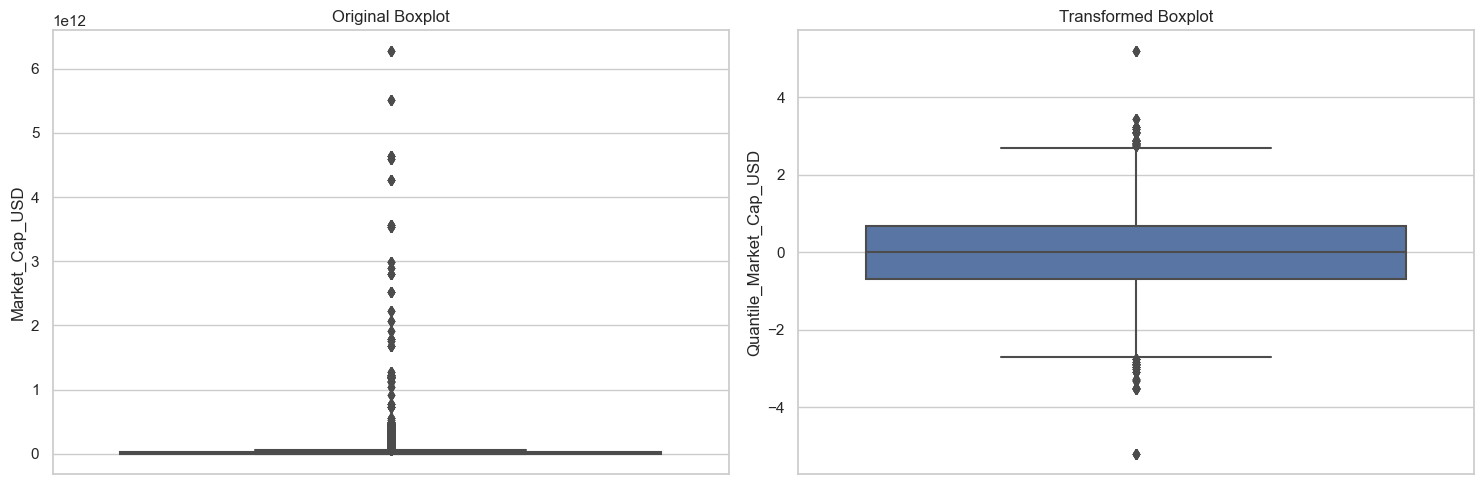


Original Data Statistics:
Skewness: 16.723
Kurtosis: 332.521

Transformed Data Statistics:
Skewness: -0.026
Kurtosis: 0.221

Descriptive Statistics:

Original Data:
count           37591.00
mean      42133812785.34
std      228108347219.05
min           2449135.49
25%        2869318806.84
50%        8135037017.00
75%       25396957209.60
max     6283031666323.00
Name: Market_Cap_USD, dtype: float64

Transformed Data:
count   37591.00
mean       -0.00
std         1.01
min        -5.20
25%        -0.69
50%         0.01
75%         0.67
max         5.20
Name: Quantile_Market_Cap_USD, dtype: float64


In [132]:
from sklearn.preprocessing import QuantileTransformer

# Apply QuantileTransformer using normal distribution
qt = QuantileTransformer(output_distribution='normal', random_state=None)
transformed_data = qt.fit_transform(df[['Market_Cap_USD']])
df['Quantile_Market_Cap_USD'] = transformed_data

# Calculate statistics for transformed data
transformed_skew = df['Quantile_Market_Cap_USD'].skew()
transformed_kurtosis = df['Quantile_Market_Cap_USD'].kurtosis()

# Visualize the transformation with QQ plots as insets and KDE curves on histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution with QQ plot inset
sns.histplot(data=df, x='Market_Cap_USD', ax=ax1, kde=True)
ax1.set_title('Original Market Cap Distribution')
ax1.set_xlabel('Original Market Cap Values')

# Add QQ plot as inset for original data
ax1_inset = ax1.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['Market_Cap_USD'], dist="norm", plot=ax1_inset)
ax1_inset.set_title('')

# Transformed distribution with QQ plot inset
sns.histplot(data=df, x='Quantile_Market_Cap_USD', ax=ax2, kde=True)
ax2.set_title('After QuantileTransformer (Normal)')
ax2.set_xlabel('Transformed Values')

# Add QQ plot as inset for transformed data
ax2_inset = ax2.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['Quantile_Market_Cap_USD'], dist="norm", plot=ax2_inset)
ax2_inset.set_title('')

plt.tight_layout()
plt.show()

# Boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, y='Market_Cap_USD', ax=ax1)
ax1.set_title('Original Boxplot')

sns.boxplot(data=df, y='Quantile_Market_Cap_USD', ax=ax2)
ax2.set_title('Transformed Boxplot')

plt.tight_layout()
plt.show()

# Print statistical tests and metrics
print("\nOriginal Data Statistics:")
print(f"Skewness: {original_skew:.3f}")
print(f"Kurtosis: {original_kurtosis:.3f}")

print("\nTransformed Data Statistics:")
print(f"Skewness: {transformed_skew:.3f}")
print(f"Kurtosis: {transformed_kurtosis:.3f}")

# Print summary statistics
print("\nDescriptive Statistics:")
print("\nOriginal Data:")
print(df['Market_Cap_USD'].describe())
print("\nTransformed Data:")
print(df['Quantile_Market_Cap_USD'].describe())

### Box Cox

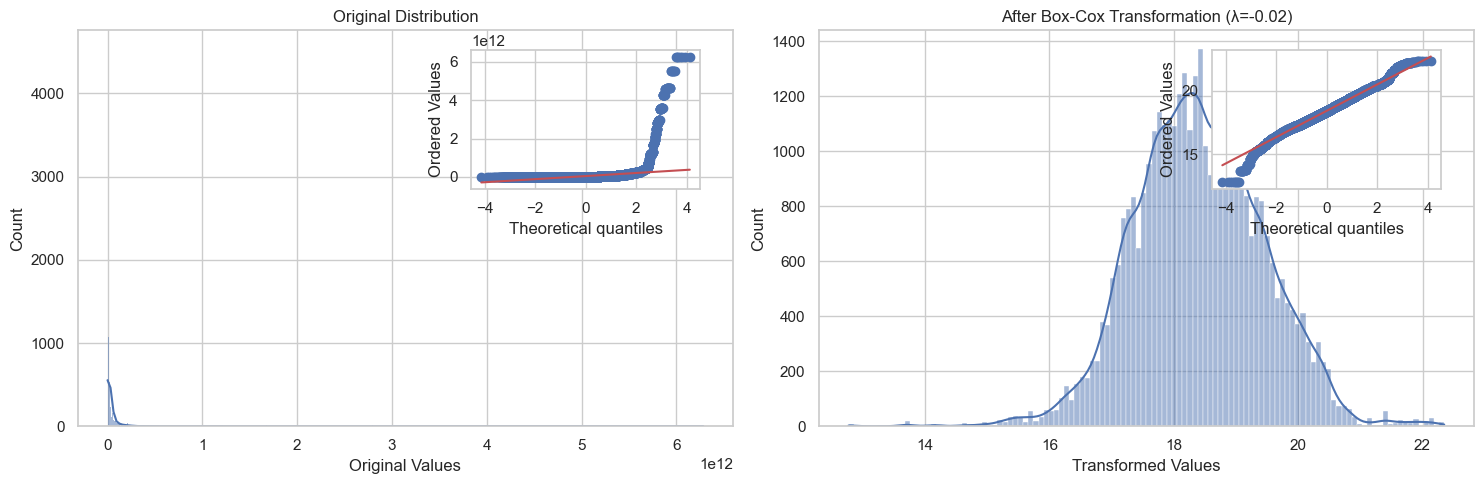

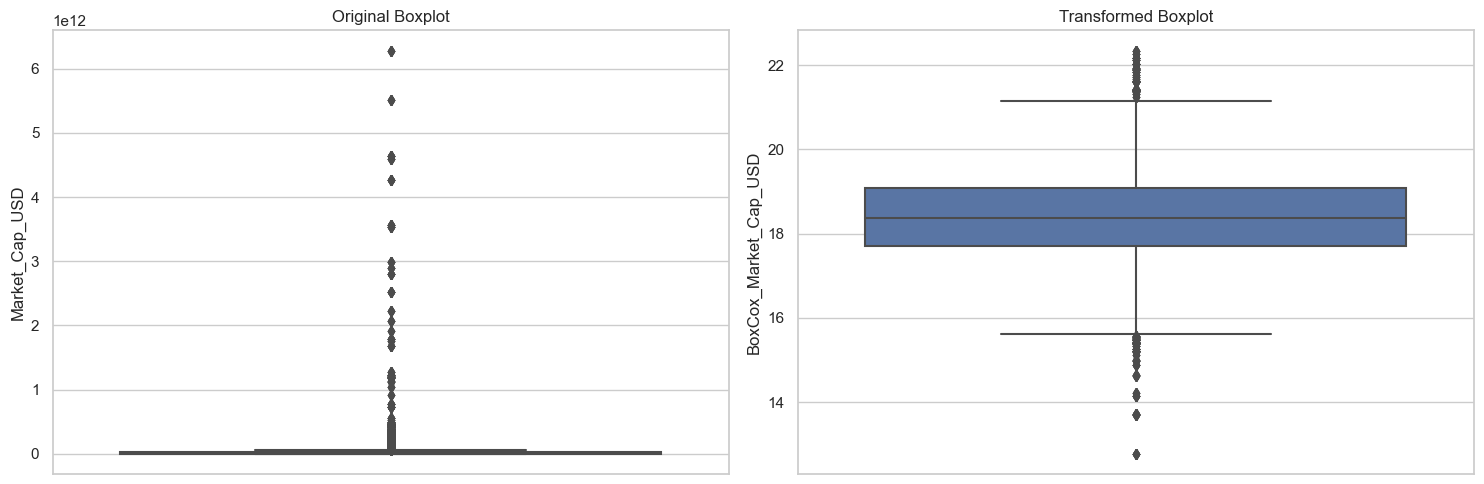


Original Data Statistics:
Skewness: 16.723
Kurtosis: 332.521

Transformed Data Statistics:
Skewness: -0.007
Kurtosis: 0.644

Descriptive Statistics:

Original Data:
count           37591.00
mean      42133812785.34
std      228108347219.05
min           2449135.49
25%        2869318806.84
50%        8135037017.00
75%       25396957209.60
max     6283031666323.00
Name: Market_Cap_USD, dtype: float64

Transformed Data:
count   37591.00
mean       18.41
std         1.04
min        12.77
25%        17.70
50%        18.38
75%        19.09
max        22.35
Name: BoxCox_Market_Cap_USD, dtype: float64


In [134]:
# Apply Box-Cox transformation
transformed_data, lambda_param = stats.boxcox(df['Market_Cap_USD'])
df['BoxCox_Market_Cap_USD'] = transformed_data

# Calculate statistics for transformed data
transformed_skew = df['BoxCox_Market_Cap_USD'].skew()
transformed_kurtosis = df['BoxCox_Market_Cap_USD'].kurtosis()

# Visualize the transformation with QQ plots as insets and KDE curves on histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution with QQ plot inset
sns.histplot(data=df, x='Market_Cap_USD', ax=ax1, kde=True)
ax1.set_title('Original Distribution')
ax1.set_xlabel('Original Values')

# Add QQ plot as inset for original data
ax1_inset = ax1.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['Market_Cap_USD'], dist="norm", plot=ax1_inset)
ax1_inset.set_title('')

# Transformed distribution with QQ plot inset
sns.histplot(data=df, x='BoxCox_Market_Cap_USD', ax=ax2, kde=True)
ax2.set_title(f'After Box-Cox Transformation (λ={lambda_param:.2f})')
ax2.set_xlabel('Transformed Values')

# Add QQ plot as inset for transformed data
ax2_inset = ax2.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['BoxCox_Market_Cap_USD'], dist="norm", plot=ax2_inset)
ax2_inset.set_title('')

plt.tight_layout()
plt.show()

# Boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, y='Market_Cap_USD', ax=ax1)
ax1.set_title('Original Boxplot')

sns.boxplot(data=df, y='BoxCox_Market_Cap_USD', ax=ax2)
ax2.set_title('Transformed Boxplot')

plt.tight_layout()
plt.show()

# Print statistical tests and metrics
print("\nOriginal Data Statistics:")
print(f"Skewness: {original_skew:.3f}")
print(f"Kurtosis: {original_kurtosis:.3f}")

print("\nTransformed Data Statistics:")
print(f"Skewness: {transformed_skew:.3f}")
print(f"Kurtosis: {transformed_kurtosis:.3f}")

# Print summary statistics
print("\nDescriptive Statistics:")
print("\nOriginal Data:")
print(df['Market_Cap_USD'].describe())
print("\nTransformed Data:")
print(df['BoxCox_Market_Cap_USD'].describe())

### Analysis
The statistical tests and vizualizations help determine if the transformation significantly improved the normality of the data:
- Skewness closer to 0 indicates more symmetric distribution
- Kurtosis closer to 0 indicates more normal-like tails
- Change in IQR ratio indicates outlier impact
- Preservation of distribution shape (skewness comparison)

The quantile and box cox transformations vastly improved the skew and distribution of the data, though the Box Cox seems to have performed better overall.

In [139]:
# verify df has all transformed columns
df.columns.unique()

Index(['account_name', 'account_id', 'Year', 'incorporated_country',
       'Primary activity', 'Primary sector', 'Market_Cap_USD',
       'Third_party_verification', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_type',
       'Scope_3_emissions_amount', 'country_ghg_avg', 'country_population_avg',
       'country_gdp_avg', 'Quantile_Market_Cap_USD', 'BoxCox_Market_Cap_USD'],
      dtype='object')

### Export Data

In [147]:
# Export to csv 
df.to_csv('Final_GHG_Data.csv', index=False)

In [148]:
# compressed csv
df.to_csv('Final_GHG_Data.csv.gz', compression='gzip', index=False)